<a href="https://colab.research.google.com/github/rokugatsu/HomeCreditDefaultRisk/blob/main/My_competition2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [ ]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

必要なデータの読み込みを行います。GCIの教材フォルダの構成を想定して、読み込んでいます。

In [ ]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
#%cd "/content/drive/MyDrive"
%cd "/content/drive/MyDrive/data/competition2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data/competition2


In [ ]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./input/"

train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.5
1,171203,0.5
2,171204,0.5
3,171205,0.5
4,171206,0.5
...,...,...
61495,232697,0.5
61496,232698,0.5
61497,232699,0.5
61498,232700,0.5


## 1. データの可視化と分析

### 1.1 データの概観
本格的な分析を行う前に、まずは簡単にデータの概観を確認します。

In [ ]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 51)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN


In [ ]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 50)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,171202,Cash loans,F,N,N,1,144000.0,961146.0,28233.0,688500.0,...,NaN,2.0,0.0,2.0,0.0,-1.0,NaN,NaN,NaN,NaN
1,171203,Cash loans,F,N,N,0,103500.0,296280.0,16069.5,225000.0,...,NaN,5.0,0.0,5.0,0.0,-212.0,NaN,NaN,NaN,NaN
2,171204,Cash loans,F,N,Y,1,180000.0,183694.5,11236.5,139500.0,...,0.389339,7.0,0.0,7.0,0.0,-428.0,0.0,1.0,1.0,1.0


特徴量が50種類もあることが分かります。このnotebookでは、50種類全ての特徴量について分析することはせず、5種類の特徴量に絞って分析を行います。今回のように特徴量が多い場合は、初めから全ての特徴量に対して、分析や前処理を行うのは大変だと思います。なので、初めは少ない特徴量で予測結果を出すことを目標に取り組んでみて、それから扱う特徴量を増やしてみると取り組みやすいです。残りの45種類の特徴量については、今までの教材やこのnotebook等を参考にして、自分の力で分析を行ってみてください。


使用する5種類の特徴量については、様々な処理の説明を行えるように選択しています。

In [ ]:
test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIA

In [ ]:
import itertools
pickup_num=5
#for gr in itertools.combinations(train.columns, pickup_num):
#  for i in range(pickup_num):
#    print(f'group{i}: {gr[i]}')
#  print('--------------')

itertools.combinations(train.columns, pickup_num)


In [ ]:
# 5種類の特徴量に絞る
use_features = ["NAME_CONTRACT_TYPE", "AMT_INCOME_TOTAL", "EXT_SOURCE_2", "OWN_CAR_AGE", "ORGANIZATION_TYPE"]
target = train["TARGET"].values
train = train[use_features]
train["TARGET"] = target
test = test[use_features]

In [ ]:
# 6種類の特徴量に絞る
#use_features = ["CNT_CHILDREN", "CNT_FAM_MEMBERS","DAYS_BIRTH", "DAYS_EMPLOYED", "REGION_RATING_CLIENT_W_CITY"]
#target = train["TARGET"].values
#train = train[use_features]
#train["TARGET"] = target
#test = test[use_features]

再度、データの確認を行います。

In [ ]:
# trainデータの確認
print(f"train shape: {train.shape}")
train.head(3)

train shape: (171202, 6)


,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,OWN_CAR_AGE,ORGANIZATION_TYPE,TARGET
0,Cash loans,112500.0,0.372591,NaN,School,0
1,Cash loans,225000.0,0.449567,NaN,XNA,0
2,Cash loans,54000.0,0.569503,NaN,Postal,0


In [ ]:
# testデータの確認
print(f"test shape: {test.shape}")
test.head(3)

test shape: (61500, 5)


,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,OWN_CAR_AGE,ORGANIZATION_TYPE
0,Cash loans,144000.0,0.720416,NaN,Kindergarten
1,Cash loans,103500.0,0.287306,NaN,School
2,Cash loans,180000.0,0.352456,NaN,Trade: type 7


### 1.2 データの可視化・分析(EDA)
データを可視化して分析を行います。この作業では、特徴量の値の分布, 欠損値, 外れ値, 相関関係などの確認を行うことでデータへの理解を深めます。この段階で得られる分析結果を元に、前処理、特徴量の作成、機械学習モデルの選択などを行うので、最終的な予測に大きく影響する重要な作業となります。Kaggle上でも様々な方がEDAを行ったコードが公開されているので、参考にしてみると良いです。

#### 1.2.1 欠損値の確認
ここでは、欠損値の確認を行います。
ほとんどの機械学習モデルでは、欠損値があるデータで学習を行うことができません。そのため、何かしらの値で欠損値を埋める必要があるので、欠損値の確認を必ず行います。

In [ ]:
# trainの欠損値を確認
train.isnull().sum()

NAME_CONTRACT_TYPE         0
AMT_INCOME_TOTAL           0
EXT_SOURCE_2             369
OWN_CAR_AGE           112992
ORGANIZATION_TYPE          0
TARGET                     0
dtype: int64

In [ ]:
# testの欠損値を確認
test.isnull().sum()

NAME_CONTRACT_TYPE        0
AMT_INCOME_TOTAL          0
EXT_SOURCE_2            130
OWN_CAR_AGE           40909
ORGANIZATION_TYPE         0
dtype: int64

EXT_SOURCE_2、OWN_CAR_AGEに欠損値があることが分かりました。後ほどこれらの欠損値の処理を行います。もちろん、今回は扱っていない特徴量についても、欠損値が存在する可能性があるので各自で確認を行ってみましょう。

#### 1.2.2 各特徴量の可視化・分析
ここでは、各特徴量について可視化を行い、どのような特徴があるのか分析します。

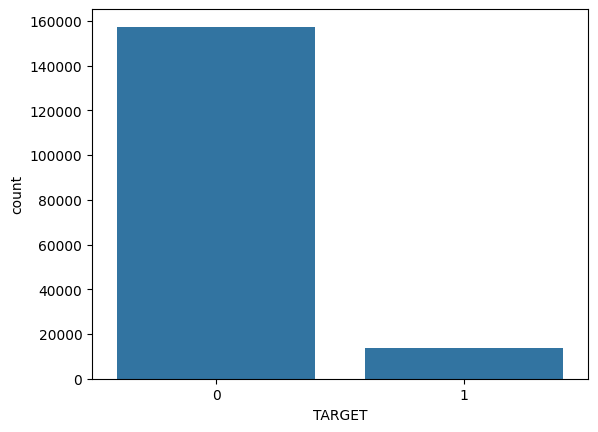

In [ ]:
# 目的変数（債務不履行かどうか）の分布
sns.countplot(data=train, x="TARGET")
plt.show()

目的変数の分布が大きく偏っていることが分かります。このように目的変数の分布が大きく偏っているデータのことを不均衡データと呼びます。


不均衡データを扱う際は、特に評価指標の選び方に注意する必要があります。例えば、今回の評価指標として正解率（Accuracy）を選択すると、全て0と予測するだけで高正解率となることがわかると思います。このような適切でない評価指標を選択すると機械学習モデルがうまく学習できない原因となります。

また、不均衡データへの対処として、目的変数の分布を均衡にしようとするアプローチもあります。多い方の目的変数のデータを減らす手法をアンダーサンプリング、少ない方の目的変数のデータを増やす方法をオーバーサンプリングと呼びます。

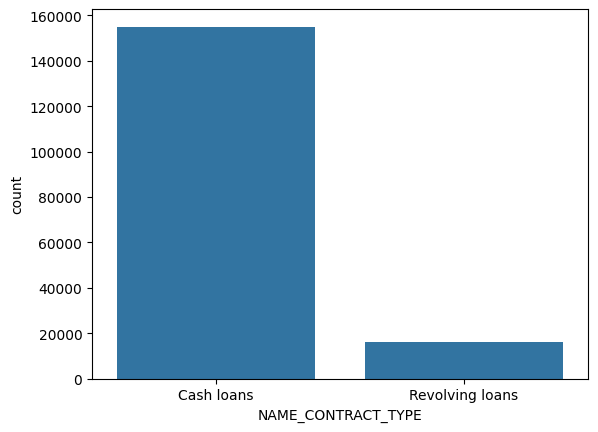

In [ ]:
# NAME_CONTRACT_TYPEの分布
sns.countplot(data=train, x="NAME_CONTRACT_TYPE")

plt.show()

NAME_CONTRACT_TYPEには、Cash loansとRevolving loansという2種類の変数が存在しますが、大きく偏りがあることが分かります。また、機械学習モデルでは数値型のデータしか扱えないため、文字列型から数値型に変換する必要があります。

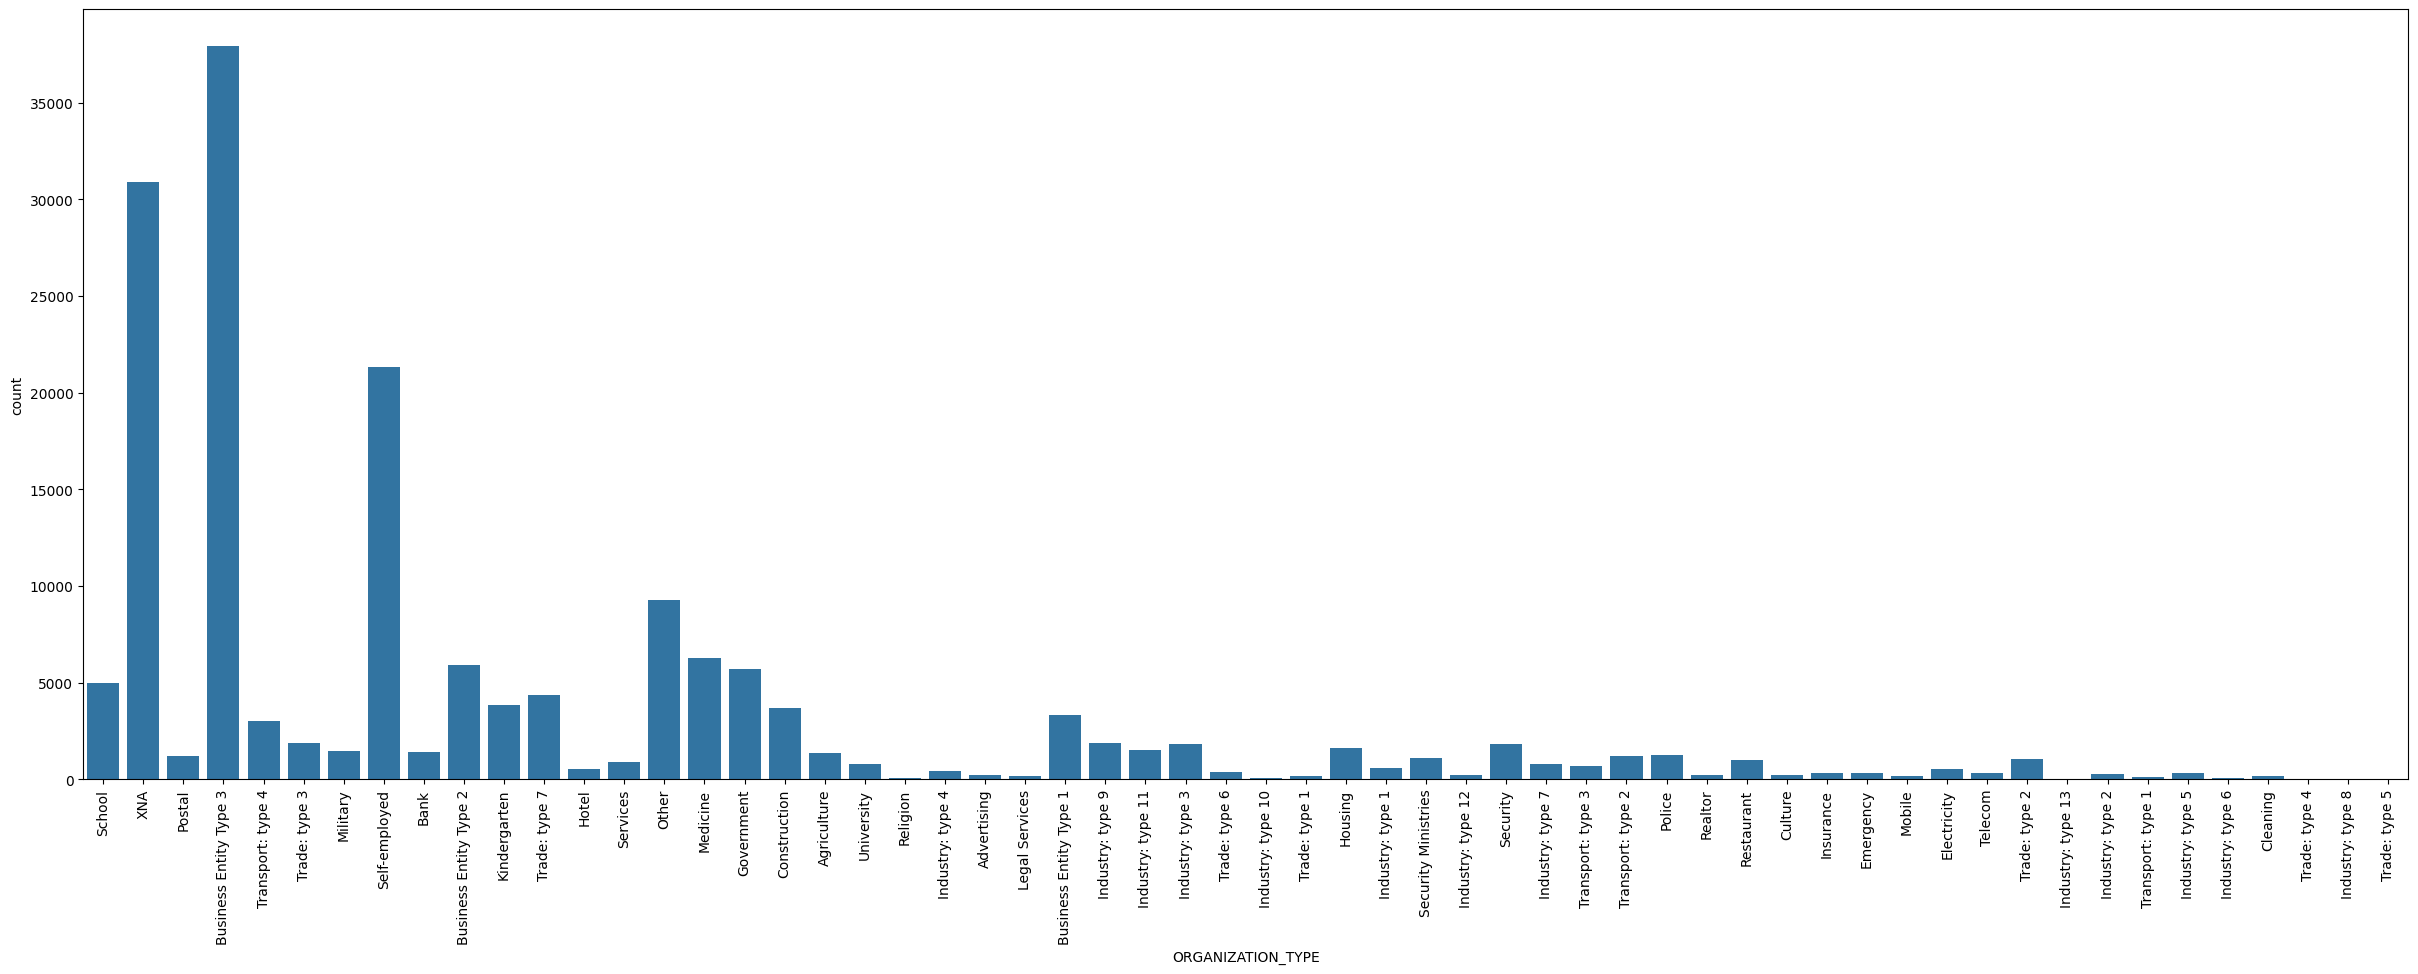

In [ ]:
# ORGANIZATION_TYPEの分布
plt.figure(figsize=(30, 10))
sns.countplot(data=train, x="ORGANIZATION_TYPE")
plt.tick_params(axis="x", rotation=90)
plt.show()

ORGANIZATION_TYPEには多くの種類があり、データ数に偏りがあることも分かります。こちらも、文字列型の特徴量なので数値型に変換する必要があります。また、左から2番目に「XNA」という変数がありますが、名前から欠損値のことであると推測することできます。

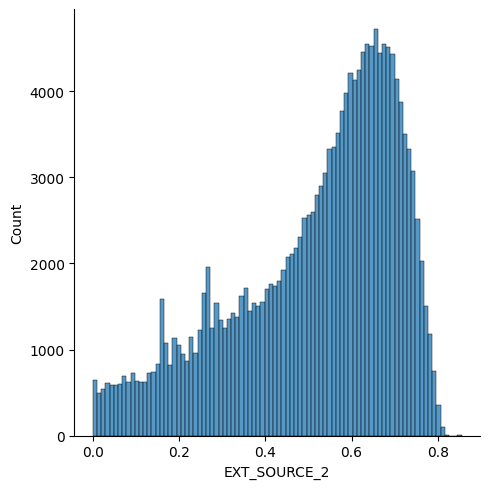

In [ ]:
# EXT_SOURCE_2の分布
sns.displot(data=train, x="EXT_SOURCE_2")
plt.show()

EXT_SOURCE_2は、0~1の範囲に正規化されていることが分かります。こちらについては、そのまま扱っても大丈夫そうです。

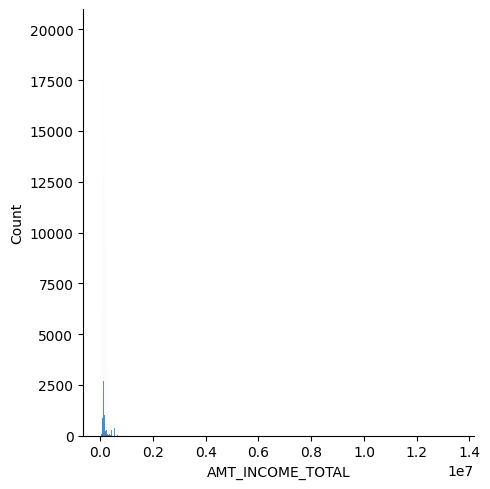

In [ ]:
# AMT_INCOME_TOTALの分布
sns.displot(data=train, x="AMT_INCOME_TOTAL")
plt.show()

AMT_INCOME_TOTALは、通常通り可視化してもうまくグラフが表示されていません。このような場合には、大きな数値を取る少数の外れ値が存在することが原因であると考えられます。今回のようなデータを可視化したい場合は、対数変換を行うと上手くグラフを表示することができます。

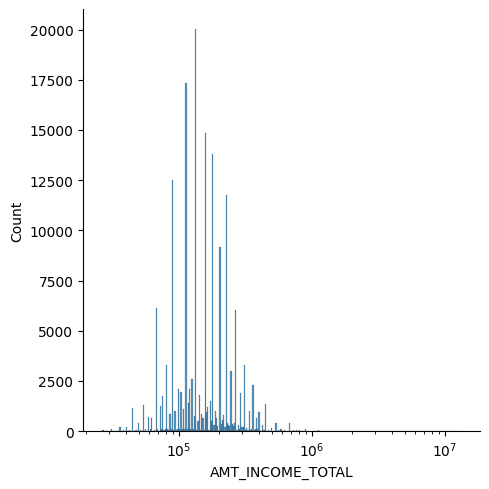

In [ ]:
# AMT_INCOME_TOTALの分布（対数変換）
sns.displot(data=train, x="AMT_INCOME_TOTAL", log_scale=10)
plt.show()

対数変換してグラフを描画することで、うまく表示することができました。しかし、年収というのは本来連続的な値を取るはずなのに、グラフをみると離散的な値をとっているようです。AMT_INCOME_TOTALの値の種類を確認してみましょう。

In [ ]:
# AMT_INCOME_TOTALの値の種類を確認
len(train["AMT_INCOME_TOTAL"].unique())

1641

trainには171202個のデータが存在するのですが、AMT_INCOME_TOTALは1641種類の値のみで構成されています。具体的に上位10個の値を確認してみましょう。

In [ ]:
# AMT_INCOME_TOTALの上位10個
train["AMT_INCOME_TOTAL"].value_counts().head(10)

AMT_INCOME_TOTAL
135000.0    19969
112500.0    17320
157500.0    14772
180000.0    13791
90000.0     12481
225000.0    11573
202500.0     9128
67500.0      6130
270000.0     6006
81000.0      3295
Name: count, dtype: int64

どうやらAMT_INCOME_TOTALは正確な年収ではなく、きりの良い数字で集計されたデータであることが分かりました。

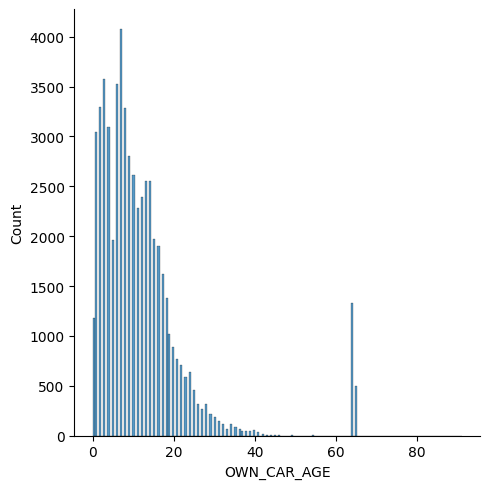

In [ ]:
# OWN_CAR_AGEの分布
sns.displot(data=train, x="OWN_CAR_AGE")
plt.show()

OWN_CAR_AGEは、値のスケールから年単位の値をとっていることが推測できます。また、0〜40あたりまでは自然な分布ですが、60〜70付近に不自然な分布が存在していることが分かります。車の購入年数がこのように急に値が上昇するとは、考えにくいので外れ値であると考えられます。

ここまで、各特徴量の可視化と分析を行いました。可視化をするのにも工夫が必要だったり、可視化を行うことでデータについての理解が深まることが実感できたと思います。今回扱っていない45種類の特徴量についても、今回の可視化などを参考に各自で可視化・分析を行ってみることで、必ず予測精度の向上につながると思います。

## 2. 前処理と特徴量作成
ここでは、上記の可視化と分析でわかったことを踏まえて、前処理と特徴量の作成を行います。

EXT_SOURCE_2の欠損値を補完します。欠損値の補完には様々な手法がありますが、今回は欠損値の数が少ないので単純に平均値で補完します。

In [ ]:
# EXT_SOURCE_2の欠損値を平均値で補完
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)

train.isnull().sum()

NAME_CONTRACT_TYPE         0
AMT_INCOME_TOTAL           0
EXT_SOURCE_2               0
OWN_CAR_AGE           112992
ORGANIZATION_TYPE          0
TARGET                     0
dtype: int64

NAME_CONTRACT_TYPEを数値型に変換します。今回は、「Cash loans」を0に「Revolving loans」を1に変換します。このように、単純に整数に置き換える手法をLabel Encodingと呼びます。

In [ ]:
# NAME_CONTRACT_TYPEの数値化（Label Encoding）
train["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)
test["NAME_CONTRACT_TYPE"].replace({'Cash loans': 0, 'Revolving loans': 1}, inplace=True)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,OWN_CAR_AGE,ORGANIZATION_TYPE,TARGET
0,0,112500.0,0.372591,NaN,School,0
1,0,225000.0,0.449567,NaN,XNA,0
2,0,54000.0,0.569503,NaN,Postal,0
3,0,67500.0,0.105235,NaN,XNA,0
4,0,157500.0,0.202490,NaN,Business Entity Type 3,1


ORGANIZATION_TYPEを数値型に変換します。今回は、変数のデータ数で数値化します。例えば、「Police」のデータ数が1279、「Bank」のデータ数が1385である場合には、「Police」を1279に、「Bank」を1385に変換します。このようにデータ数に置き換える手法をCount Encodingと呼びます。

In [ ]:
# ORGANIZATION_TYPEの数値化（Count Encoding）
organization_ce = train["ORGANIZATION_TYPE"].value_counts()
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(organization_ce)
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(organization_ce)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,OWN_CAR_AGE,ORGANIZATION_TYPE,TARGET
0,0,112500.0,0.372591,NaN,4991,0
1,0,225000.0,0.449567,NaN,30898,0
2,0,54000.0,0.569503,NaN,1185,0
3,0,67500.0,0.105235,NaN,30898,0
4,0,157500.0,0.202490,NaN,37943,1


OWN_CAR_AGEの処理を行います。まず、不自然な60以上の外れ値を欠損値として置き換えます。

In [ ]:
# OWN_CAR_AGEの60以上の値（外れ値）を欠損値扱いする
train.loc[train["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan
test.loc[test["OWN_CAR_AGE"] >= 60, "OWN_CAR_AGE"] = np.nan

次に、OWN_CAR_AGEの欠損値の処理について考えます。元々のOWN_CAR_AGEにはデータ数171202に対して欠損値が112992個ありました。このように欠損値が多い場合には、適切に欠損値を補完することは難しく現実的ではありません。そのため、今回はOWN_CAR_AGEを0～9年、10～19年のように10年単位でグループ分けした後に、One Hot Encodingを行うことで欠損値の対処を行います。

In [ ]:
# OWN_CAR_AGEをグループ分け
train["OWN_CAR_AGE"] = train["OWN_CAR_AGE"] // 10
test["OWN_CAR_AGE"] = test["OWN_CAR_AGE"] // 10

train["OWN_CAR_AGE"].unique()

array([nan,  0.,  2.,  1.,  3.,  4.,  5.])

In [ ]:
# OWN_CAR_AGEをOne Hot Encoding
train_car_age_ohe = pd.get_dummies(train["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")
test_car_age_ohe = pd.get_dummies(test["OWN_CAR_AGE"]).add_prefix("OWN_CAR_AGE_")

train = pd.concat([train, train_car_age_ohe], axis=1)
test = pd.concat([test, test_car_age_ohe], axis=1)

train.drop('OWN_CAR_AGE', axis=1, inplace=True)
test.drop('OWN_CAR_AGE', axis=1, inplace=True)

train.head(5)

,NAME_CONTRACT_TYPE,AMT_INCOME_TOTAL,EXT_SOURCE_2,ORGANIZATION_TYPE,TARGET,OWN_CAR_AGE_0.0,OWN_CAR_AGE_1.0,OWN_CAR_AGE_2.0,OWN_CAR_AGE_3.0,OWN_CAR_AGE_4.0,OWN_CAR_AGE_5.0
0,0,112500.0,0.372591,4991,0,False,False,False,False,False,False
1,0,225000.0,0.449567,30898,0,False,False,False,False,False,False
2,0,54000.0,0.569503,1185,0,False,False,False,False,False,False
3,0,67500.0,0.105235,30898,0,False,False,False,False,False,False
4,0,157500.0,0.202490,37943,1,False,False,False,False,False,False


## 3. 機械学習モデルの作成
ここでは、機械学習モデルの作成を行います。

まずは、必要なライブラリを読み込みます。

- train_test_split：データを訓練用データと評価用データに分割する。
- StandardScaler：データを標準化する。
- roc_auc_score：今回の評価指標であるAUCを計算する。

In [ ]:
# ライブラリの読み込み
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

データを説明変数と目的変数に分割します。今回の目的変数は「TARGET」なので、それ以外が説明変数となります。

In [ ]:
# 目的変数と説明変数に分割
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values

データを標準化します。標準化とは、平均が0で分散が1となるように値を変換する操作です。ロジスティック回帰やニューラルネットワークなどの一部のモデルでは、このように値のスケールを揃えないと学習が上手くいきません。

In [ ]:
# 標準化
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)
X_test_std = sc.transform(X_test)

学習用データのうち、7割を訓練データ、3割を評価データとして分割します。このように、学習データの一部を学習に用いずに、評価用として取っておく手法をホールドアウト法と呼びます。これにより、未知のデータに対する予測精度（汎化性能）を算出することが出来ます。

In [ ]:
# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_std, y, test_size=0.3, stratify=y, random_state=0)

ロジスティック回帰と多層パーセプトロンでモデルを作成してみます。

In [ ]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

lr_train_pred = lr.predict_proba(X_train)[:, 1]
lr_valid_pred = lr.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lr_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lr_valid_pred)}")

Train Score: 0.6617244589454646
Valid Score: 0.6630685833844308


In [ ]:
# MLPClassifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
mlp.fit(X_train, y_train)

mlp_train_pred = mlp.predict_proba(X_train)[:, 1]
mlp_valid_pred = mlp.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, mlp_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, mlp_valid_pred)}")

Train Score: 0.6758258246974346
Valid Score: 0.6696073973482656


つぎに、勾配ブースティング木（GBDT）と呼ばれるモデルを作成してみたいと思います。GBDTは、使いやすさと精度の高さから、Kaggleなどの分析コンペでよく使用されているモデルです。GBDTの特徴として以下のような点が挙げられます。
- 欠損値のあるデータを学習できる。
- 標準化などの値のスケーリングが不要。
- 精度が高い。
- 特徴量間の相互作用が反映される。
- 特徴量が多くても精度が落ちにくく、速度が速い。

今回はGBDTの中でも代表的なxgboostとlightgbmを扱います。

In [ ]:
# XGBClassifier
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)
xgb.fit(X_train, y_train)

xgb_train_pred = xgb.predict_proba(X_train)[:, 1]
xgb_valid_pred = xgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, xgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, xgb_valid_pred)}")

Train Score: 0.7646748296826761
Valid Score: 0.654550753884773


In [ ]:
# LGBMClassifier
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=0)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

[LightGBM] [Info] Number of positive: 9675, number of negative: 110166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 119841, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080732 -> initscore=-2.432443
[LightGBM] [Info] Start training from score -2.432443
Train Score: 0.7235077072555903
Valid Score: 0.6694850623021139


ここまでで、4つのモデルを作成しました。ここでは、アンサンブルと呼ばれる複数のモデルを組み合わせることを行います。アンサンブルには、様々な手法がありますが、今回はシンプルに4つのモデルの平均値をとることにします。

In [ ]:
train_pred = (lr_train_pred + mlp_train_pred + lgb_train_pred + xgb_train_pred)/4
valid_pred = (lr_valid_pred + mlp_valid_pred + lgb_valid_pred + xgb_valid_pred)/4

print(f"Train Score: {roc_auc_score(y_train, train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)}")

Train Score: 0.7253468618018353
Valid Score: 0.6705849742883124


今回は、アンサンブルをしても精度の向上には繋がらなかったため、最終的なモデルは一番スコアの高かったxgboostを用いることにします。

やっぱり多様なModelを試してみる

In [ ]:
#from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [ ]:
models = [
    ("GBM", GradientBoostingClassifier(random_state=42)),
    #("Histogram Boosting", HistGradientBoostingClassifier(random_state=42)),
    #("SVM", SVC(probability=True, random_state=42)),
    ("XGBoost", XGBClassifier(random_state=42)),
    #("Catboost", CatBoostClassifier(verbose=0, random_state=42)),
    ("Regression", LogisticRegression(max_iter=600, random_state=42)),
    #("Random Forest", RandomForestClassifier(random_state=42)),
    #("K-Nearest", KNeighborsClassifier()),
    ("LGBMClassifier",LGBMClassifier(boosting_type='goss',random_state=42, verbose=-1))
    #("MLPClassifier", MLPClassifier(hidden_layer_sizes=(100, 100, 10), random_state=42))
]

for i, (name, model) in enumerate(models, 1):
    model.fit(X_train, y_train)
    train_pred = model.predict_proba(X_train)[:, 1]
    valid_pred = model.predict_proba(X_valid)[:, 1]
    print(f"Train Score: {roc_auc_score(y_train, train_pred)} - {name}")
    print(f"Valid Score: {roc_auc_score(y_valid, valid_pred)} - {name}")

Train Score: 0.6843892080924061 - GBM
Valid Score: 0.6749387481871962 - GBM
Train Score: 0.7646748296826761 - XGBoost
Valid Score: 0.654550753884773 - XGBoost
Train Score: 0.6617244589454646 - Regression
Valid Score: 0.6630685833844308 - Regression
Train Score: 0.7228544952200628 - LGBMClassifier
Valid Score: 0.6646654471730988 - LGBMClassifier


In [ ]:
voting_clf = VotingClassifier(estimators=models, voting='soft')
voting_clf.fit(X_train, y_train)
#acc = cross_val_score(voting_clf, X_train_std, y_train, cv=5).mean()
#acc = cross_val_score(voting_clf, X_train_std, y_train, cv=5).argmax(axis=1)
#acc = cross_val_score(voting_clf, X_train_std, y_train, cv=5).max()
#print(round(acc*1000)/10, "% - Voting")

roc_auc_score_train = cross_val_score(voting_clf, X_train, y_train, cv=5).max()
roc_auc_score_pred = cross_val_score(voting_clf, X_valid, y_valid, cv=5).max()

print(f"ROC_AUC_Score Train: {roc_auc_score_train} - Voting")
print(f"ROC_AUC_Score Pred: {roc_auc_score_pred} - Voting")


ROC_AUC_Score Train: 0.9193124452417706 - Voting
ROC_AUC_Score Pred: 0.9192951713395638 - Voting


## 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [ ]:
# テストデータに対する予測値の作成
#pred = xgb.predict_proba(X_test)[:, 1]
pred= voting_clf.predict_proba(X_test)[:, 1]

In [ ]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

,SK_ID_CURR,TARGET
0,171202,0.280539
1,171203,0.308856
2,171204,0.318308
3,171205,0.293393
4,171206,0.303944
...,...,...
61495,232697,0.293649
61496,232698,0.282747
61497,232699,0.283669
61498,232700,0.295298


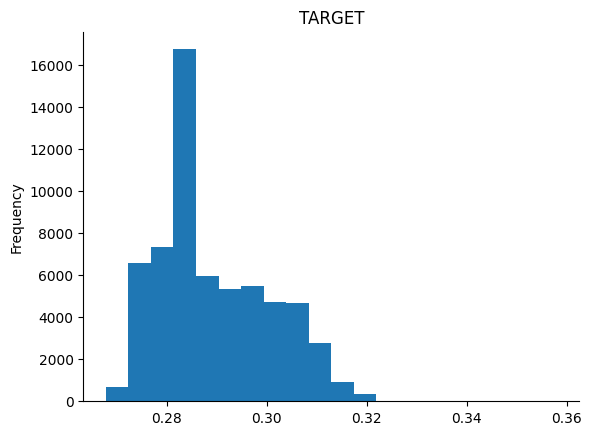

In [ ]:
from matplotlib import pyplot as plt
sample_sub['TARGET'].plot(kind='hist', bins=20, title='TARGET')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# 提出用のcsvファイルを作成
#sample_sub.to_csv('submission.csv',index=False)
sample_sub.to_csv('sub_competition2.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！

In [ ]:
from google.colab import files
files.download('sub_competition2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>